In [47]:
## import codecs
import os
import os.path
import shutil
import string
import sys
import warnings
from typing import Any, Callable, Dict, List, Optional, Tuple
from urllib.error import URLError
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
from PIL import Image

#from .utils import download_and_extract_archive, extract_archive, verify_str_arg, check_integrity
from torchvision.datasets.vision import VisionDataset
import pandas as pd

class Facekeypoint(VisionDataset):


    training_file = "training.pt"
    test_file = "test.pt"


    @property
    def train_labels(self):
        warnings.warn("train_labels has been renamed targets")
        return self.targets

    @property
    def test_labels(self):
        warnings.warn("test_labels has been renamed targets")
        return self.targets

    @property
    def train_data(self):
        warnings.warn("train_data has been renamed data")
        return self.data

    @property
    def test_data(self):
        warnings.warn("test_data has been renamed data")
        return self.data

    def __init__(
        self,
        root: str = None,
        train: bool = True,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        split : float = 0.2
      
    ) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)
        self.train = train  # training set or test set
        self.split = split
        self.height=96
        self.width=96
#        print(self.train)
        

        
	
        self.data, self.targets = self._load_data()
 
        

        
    def _load_data(self):
        df_data = pd.read_csv("training.csv")
        #print(df_data.columns)

        # drop all the rows with missing values
        df_data = df_data.dropna()
        len_data = len(df_data)
        # calculate the validation data sample length
        
        valid_split = int(len_data * self.split)
        # calculate the training data samples length
        train_split = int(len_data - valid_split)     
        
        if self.train == True:
            samples = df_data.iloc[:train_split][:]
            samples, keypoints = self.listtoarray(samples)
            print(f"Training sample instances: {len(samples)}")
        elif self.train == False:
            samples = df_data.iloc[-valid_split:][:]
            samples, keypoints = self.listtoarray(samples)
            print(f"Validation sample instances: {len(samples)}")
                
        return samples, keypoints
    
    def listtoarray(self, samples):
        #store the pixel values after extracting them from the Image column
        image_pixels = []
        keypoints =[]
        for i in tqdm(range(len(samples))):
            #pixel values by space as they are space separated in the CSV file as well
            img = samples.Image.iloc[i].split(' ')
            image_pixels.append(img)
            keypoints.append(samples.iloc[i][:30].tolist())
        #images = np.array(image_pixels, dtype='float32')
        #keypoints = np.array(keypoints, dtype='float32')
        # reshape the keypoints
        #keypoints = keypoints.reshape(-1, 2)
      
       
        
        #return images,keypoints
        return image_pixels,keypoints
       
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]
        img =np.array(img, dtype='uint8').reshape(self.height,self.width)
        img = torch.Tensor(img)
        img = img[None,:]
        target = torch.Tensor(target)/96
        

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target



    def __len__(self) -> int:
        return len(self.data)
    
    @property
    def raw_folder(self) -> str:
        return os.path.join(self.root, self.__class__.__name__, "raw")

    @property
    def processed_folder(self) -> str:
        return os.path.join(self.root, self.__class__.__name__, "processed")

    @property
    def class_to_idx(self) -> Dict[str, int]:
        return {_class: i for i, _class in enumerate(self.classes)}

    def _check_exists(self) -> bool:
        return all(
            check_integrity(os.path.join(self.raw_folder, os.path.splitext(os.path.basename(url))[0]))
            for url, _ in self.resources
        )

    def download(self) -> None:
        """Download the MNIST data if it doesn't exist already."""

        if self._check_exists():
            return

        os.makedirs(self.raw_folder, exist_ok=True)

        # download files
        for filename, md5 in self.resources:
            for mirror in self.mirrors:
                url = f"{mirror}{filename}"
                try:
                    print(f"Downloading {url}")
                    download_and_extract_archive(url, download_root=self.raw_folder, filename=filename, md5=md5)
                except URLError as error:
                    print(f"Failed to download (trying next):\n{error}")
                    continue
                finally:
                    print()
                break
            else:
                raise RuntimeError(f"Error downloading {filename}")

    def extra_repr(self) -> str:
        split = "Train" if self.train is True else "Test"
        return f"Split: {split}"

    # get the training and validation data samples
print('\n-------------- PREPARING DATA --------------\n')
train_data=Facekeypoint(train = True)
valid_data = Facekeypoint(train = False)

print('\n-------------- DATA PREPRATION DONE --------------\n')
    # prepare data loaders
train_loader = DataLoader(train_data,
                              batch_size=256,
                              shuffle=True)
valid_loader = DataLoader(valid_data,
                              batch_size=256,
                              shuffle=False)




-------------- PREPARING DATA --------------



100%|██████████| 1712/1712 [00:01<00:00, 1341.86it/s]


Training sample instances: 1712


100%|██████████| 428/428 [00:00<00:00, 1446.20it/s]

Validation sample instances: 428

-------------- DATA PREPRATION DONE --------------



In [52]:
OUTPUT_PATH = '/home/nandhini/NandhiniMathivananRnD/outputs'

BATCH_SIZE = 256
LR = 0.0001
EPOCHS = 150
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#train test split
TEST_SPLIT = 0.2
SHOW_DATASET_PLOT = True



In [53]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import os
import torch
from copy import deepcopy

class FaceKeypointModel(torch.nn.Module):
    def __init__(self, freeze_resnet = False):
        super(FaceKeypointModel, self).__init__()
        
        # Convert 1 filter 3 filter because resnet accepts 3 filter only
        self.conv1 = torch.nn.Conv2d( in_channels=1, out_channels=3, kernel_size=(3, 3), stride=1, padding=1, padding_mode='zeros' )
        
        # Resnet Architecture
        self.resnet18 = models.resnet18(pretrained=True)
        if freeze_resnet:
            for param in self.resnet18.parameters():
                param.requires_grad = False
        # replacing last layer of resnet
        # by default requires_grad in a layer is True
        self.resnet18.fc = torch.nn.Linear(self.resnet18.fc.in_features, 384) 
        

        self.relu = torch.nn.ReLU()
        self.mu = torch.nn.Linear(384, 30)
        self.loga = torch.nn.Linear(384, 30)
        self.logb = torch.nn.Linear(384, 30)
        self.logl = torch.nn.Linear(384, 30)
        
#        self.linear2 = torch.nn.Linear(30, 4) 
        
    def forward(self, x):
        y0 = self.conv1(x)
        y1 = self.resnet18(y0)
        y_relu = self.relu(y1)
        mu = self.mu(y_relu)
        alpha = F.softplus(self.loga(y_relu))
        beta = F.softplus(self.logb(y_relu))
        lamda = F.softplus(self.logl(y_relu))
        return mu, alpha, beta, lamda



In [54]:
class EvidentialLoss(torch.nn.Module):
    def __init__(self, mu, alpha, beta, lamda, targets, weight=None, size_average=True):
        super(EvidentialLoss, self).__init__()
        self.mu = mu
        self.alpha = alpha
        self.beta = beta
        self.lamda = lamda
        self.targets = targets

    def forward(self,  mu, alpha, beta, lamda, targets,smooth=1):
        targets = targets.view(-1)
        y = self.mu.view(-1) #first column is mu,delta, predicted value
        loga = self.alpha.view(-1) #alpha
        logb = self.beta.view(-1) #beta
        logl = self.lamda.view(-1) #lamda

        a = torch.exp(loga)
        b = torch.exp(logb)
        l = torch.exp(logl)


        term1 = (torch.exp(torch.lgamma(a - 0.5)))/(4 * torch.exp(torch.lgamma(a)) * l * torch.sqrt(b))

        term2 = 2 * b *(1 + l) + (2*a - 1)*l*(y - targets)**2


        J = term1 * term2
 
        Kl_divergence = torch.abs(y - targets) * (2*a + l)
  

        loss = J + Kl_divergence

 
        return loss.mean()

In [55]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn
import matplotlib
import config
import utils
from tqdm import tqdm
matplotlib.style.use('ggplot')
import argparse
import numpy as np

# model 
model = FaceKeypointModel().to(DEVICE)
# optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)





def validate(model, dataloader, data, epoch):
    print('Validating')
  
    valid_running_loss = 0.0
    val_difference = []
    counter = 0
  

    with torch.no_grad():
        for i, [image,keypoints] in tqdm(enumerate(valid_loader)):
            counter += 1
            image, keypoints = image.to(DEVICE), keypoints.to(DEVICE)
        
            keypoints = keypoints.view(keypoints.size(0), -1)
            mu,alpha,beta,lamda = model(image)
            loss_func = EvidentialLoss(mu,alpha,beta,lamda, keypoints) 
            loss = loss_func(mu,alpha,beta,lamda, keypoints)
            valid_running_loss += loss.item()
            val_difference.extend(abs(keypoints - mu).squeeze(1).tolist())
 
    diff = np.average(val_difference)    
    valid_loss = np.average(valid_running_loss)
    return valid_loss,diff





In [56]:

def train_func():
    last_loss = 10000
    patience = 5
    triggertimes = 0
    model_save_loc = "/home/nandhini/NandhiniMathivananRnD/outputs/ne.pth"
    print('Training')
    Train_epoch_loss = []
    Val_epoch_loss = []
    
    for e in range(EPOCHS):
    
        model.train()
        train_running_loss = 0.0
        counter = 0
        

        
       
        for i, [image,keypoints] in tqdm(enumerate(train_loader)):
            counter += 1  


            image, keypoints = image.to(DEVICE), keypoints.to(DEVICE)
            keypoints = keypoints.view(keypoints.size(0), -1)

            optimizer.zero_grad()
            mu,alpha,beta,lamda = model(image)


            loss_func = EvidentialLoss(mu,alpha,beta,lamda, keypoints) 
            loss = loss_func(mu,alpha,beta,lamda, keypoints)
            train_running_loss += loss.item()

            loss.backward()
            optimizer.step()
   
        
               
        train_loss = np.average(train_running_loss)
        Train_epoch_loss.append(train_loss)
        
        model.eval()
        
        with torch.no_grad():
            
            validation_loss = validate(model, valid_loader, valid_data, e)
            val_loss = validation_loss[0]
            pred = validation_loss[1]
            Val_epoch_loss.append(val_loss)
            
        print("Epoch: {}/{}.. ".format(e+1, EPOCHS),
              "Training Loss: {:.3f}.. ".format(train_loss),
              "Validation Loss: {:.3f}.. ".format(val_loss))

        current_loss = val_loss
        print('The Current Loss:', current_loss)
        
        if current_loss > last_loss:
            trigger_times += 1
            print('Trigger Times:', trigger_times, '\n')
            
            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                break
                
            
        else:
            print('trigger times: 0', '\n')
            trigger_times = 0
            torch.save(model, model_save_loc)
            
        last_loss = current_loss
        
                                     
        
    plt.figure(figsize=(10, 7))
    plt.plot(Train_epoch_loss, color='orange', label='train loss')
    plt.plot(Val_epoch_loss, color='red', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('/home/nandhini/NandhiniMathivananRnD/outputs/ne_loss.png')
    plt.show()

    print('DONE TRAINING')
                                     
    return model,Val_epoch_loss, Train_epoch_loss
                                     
                                     
                                     
                
    
    
    
    




In [57]:

face_model,valid_loss, training_loss = train_func()

0it [00:00, ?it/s]

Training


7it [00:37,  5.36s/it]
0it [00:00, ?it/s]

Validating


2it [00:02,  1.34s/it]
0it [00:00, ?it/s]

Epoch: 1/150..  Training Loss: 23.646..  Validation Loss: 5.609.. 
The Current Loss: 5.6091344356536865
trigger times: 0 



7it [00:38,  5.49s/it]
0it [00:00, ?it/s]

Validating


0it [00:01, ?it/s]


KeyboardInterrupt: 

In [62]:
import scipy.stats 

def test_validation(model, valid_loader):
    
    model.eval()
#     model.to('cuda')
   
    val_difference =[]
    pred_x = []
    pred_y = [] 
    true_x = []
    true_y = []
    var_x = []
    var_y = []
    img = []
    ent = []
    vald = []
    st_x = []
    st_y = []
    with torch.no_grad():
        for i, [image,keypoints] in tqdm(enumerate(valid_loader)):

            image, keypoints = image.to(DEVICE), keypoints.to(DEVICE)

            keypoints = keypoints.view(keypoints.size(0), -1)

            key_x = [[keypoints[j][i].item() for i in range(len(keypoints[0])) if i%2 == 0] for j in range(len(keypoints))]
            key_y = [[keypoints[j][i].item() for i in range(len(keypoints[0])) if i%2 != 0] for j in range(len(keypoints))]
            true_x.extend(key_x)
            true_y.extend(key_y)

            
            mu,alpha,beta,lamda = model(image)
     
            variance = beta / ((alpha -1)*lamda)
           
            out_x = [[mu[j][i].item() for i in range(len(mu[0])) if i%2 == 0] for j in range(len(mu))]
            out_y = [[mu[j][i].item() for i in range(len(mu[0])) if i%2 != 0] for j in range(len(mu))]
           
            pred_x.extend(out_x)
            pred_y.extend(out_y)
            
            v_x = [[variance[j][i].item() for i in range(len(variance[0])) if i%2 == 0] for j in range(len(variance))]
            v_y = [[variance[j][i].item() for i in range(len(variance[0])) if i%2 != 0] for j in range(len(variance))]
            var_x.extend(v_x)
            var_y.extend(v_y)
            
            loss = EvidentialLoss(mu,alpha,beta,lamda, keypoints)
            std = np.sqrt(variance)
            
            s_x = [[std[j][i].item() for i in range(len(std[0])) if i%2 == 0] for j in range(len(std))]
            
            s_y = [[std[j][i].item() for i in range(len(std[0])) if i%2 != 0] for j in range(len(std))]
          
            
            st_x.extend(s_x)
            st_y.extend(s_y)
            
            en = scipy.stats.norminvgauss(a = alpha, b = beta, loc=mu, scale=std).entropy()
            
            ent.extend(np.average(en, axis = 1))
            
            

           

            img.extend(image.numpy())
       
            val = (abs(keypoints - mu).squeeze(1).tolist())
            vald.extend(np.average(val, axis = 1))

    
    return ent, vald ,st_x, st_y,pred_x,pred_y, true_x, true_y, img

In [63]:
import torch
val_model = torch.load("/home/nandhini/NandhiniMathivananRnD/src/normal_01/evidential/ne.pth")
ent, vald,  st_x, st_y ,pred_x,pred_y,true_x, true_y, img = test_validation(val_model, valid_loader)
print(pred_x)

2it [00:27, 13.75s/it]

[[0.6681258678436279, 0.25107571482658386, 0.5984726548194885, 0.7922749519348145, 0.3992170989513397, 0.22729764878749847, 0.5591949820518494, 0.8301920890808105, 0.43908175826072693, 0.17516528069972992, 0.518162190914154, 0.6702272295951843, 0.35243934392929077, 0.5146990418434143, 0.5401541590690613], [0.657042920589447, 0.29654228687286377, 0.5823556184768677, 0.7792869806289673, 0.3886371850967407, 0.2738785743713379, 0.5548589825630188, 0.8070901036262512, 0.3831931948661804, 0.18485191464424133, 0.525520384311676, 0.6775638461112976, 0.3700372278690338, 0.5067538619041443, 0.5156359076499939], [0.6879159808158875, 0.313901424407959, 0.6183100938796997, 0.7906436920166016, 0.4025563895702362, 0.23968225717544556, 0.5764628648757935, 0.8426546454429626, 0.39876654744148254, 0.1534591019153595, 0.47599977254867554, 0.7019825577735901, 0.3265973627567291, 0.5024936199188232, 0.5039121508598328], [0.6944921016693115, 0.29421553015708923, 0.6057634949684143, 0.8027822971343994, 0.400

In [68]:
final = pd.DataFrame(columns=['image_label', 'keypoints','entropy','std_x','std_y','Val diff','true_value_x','true_value_y','predicted_value_x','predicted_value_y', 'pixel_value'])

for i in range(len(img)):
    for j in range(len(pred_x[i])):
        dictionary = pd.Series(data = {
        'image_label': i+1 ,
        'keypoints' : j+1 ,
        'true_value_x' : true_x[i][j],
        'true_value_y' : true_y[i][j],
        'entropy' : ent[i],
        'Val diff' : vald[i],
        'predicted_value_x' :  pred_x[i][j] ,
        'predicted_value_y' :  pred_y[i][j] ,
        'std_x' : st_x[i][j],
        'std_y' : st_y[i][j],
        'pixel_value' : img [i]
        })

        final = final.append(dictionary , ignore_index = True)

In [69]:
final

,image_label,keypoints,entropy,std_x,std_y,Val diff,true_value_x,true_value_y,predicted_value_x,predicted_value_y,pixel_value
0,1,1,-0.796531,0.156633,0.136974,0.020221,0.696891,0.358050,0.668126,0.381021,"[[[22.0, 22.0, 22.0, 21.0, 21.0, 21.0, 21.0, 2..."
1,1,2,-0.796531,0.185810,0.157683,0.020221,0.313758,0.380679,0.251076,0.381126,"[[[22.0, 22.0, 22.0, 21.0, 21.0, 21.0, 21.0, 2..."
2,1,3,-0.796531,0.135474,0.143243,0.020221,0.589089,0.388794,0.598473,0.398860,"[[[22.0, 22.0, 22.0, 21.0, 21.0, 21.0, 21.0, 2..."
3,1,4,-0.796531,0.174782,0.170731,0.020221,0.772322,0.358700,0.792275,0.404578,"[[[22.0, 22.0, 22.0, 21.0, 21.0, 21.0, 21.0, 2..."
4,1,5,-0.796531,0.123247,0.149548,0.020221,0.402516,0.404026,0.399217,0.397270,"[[[22.0, 22.0, 22.0, 21.0, 21.0, 21.0, 21.0, 2..."
...,...,...,...,...,...,...,...,...,...,...,...
6415,428,11,-0.765252,0.205940,0.184957,0.020122,0.520561,0.617389,0.485122,0.600793,"[[[68.0, 19.0, 19.0, 23.0, 19.0, 26.0, 23.0, 1..."
6416,428,12,-0.765252,0.172095,0.227255,0.020122,0.756254,0.748563,0.710487,0.779949,"[[[68.0, 19.0, 19.0, 23.0, 19.0, 26.0, 23.0, 1..."
6417,428,13,-0.765252,0.177853,0.184227,0.020122,0.356591,0.805619,0.326522,0.770717,"[[[68.0, 19.0, 19.0, 23.0, 19.0, 26.0, 23.0, 1..."
6418,428,14,-0.765252,0.168082,0.126668,0.020122,0.537494,0.791287,0.514967,0.748279,"[[[68.0, 19.0, 19.0, 23.0, 19.0, 26.0, 23.0, 1..."


In [79]:
final1 = final.sort_values('Val diff').reset_index(drop=True)
final3 = final1.tail(75).reset_index(drop=True)
final3

,image_label,keypoints,entropy,std_x,std_y,Val diff,true_value_x,true_value_y,predicted_value_x,predicted_value_y,pixel_value
0,168,12,-0.706903,0.194870,0.238260,0.062801,0.543915,0.751617,0.667714,0.763600,"[[[6.0, 5.0, 8.0, 9.0, 17.0, 60.0, 104.0, 77.0..."
1,168,15,-0.706903,0.161685,0.223276,0.062801,0.431864,0.767725,0.513675,0.806425,"[[[6.0, 5.0, 8.0, 9.0, 17.0, 60.0, 104.0, 77.0..."
2,168,14,-0.706903,0.174215,0.137464,0.062801,0.440447,0.727513,0.533875,0.759967,"[[[6.0, 5.0, 8.0, 9.0, 17.0, 60.0, 104.0, 77.0..."
3,168,2,-0.706903,0.191964,0.167061,0.062801,0.382009,0.390849,0.320522,0.393493,"[[[6.0, 5.0, 8.0, 9.0, 17.0, 60.0, 104.0, 77.0..."
4,168,3,-0.706903,0.149821,0.151773,0.062801,0.573241,0.457812,0.611589,0.356843,"[[[6.0, 5.0, 8.0, 9.0, 17.0, 60.0, 104.0, 77.0..."
...,...,...,...,...,...,...,...,...,...,...,...
70,321,3,-0.722904,0.145583,0.158459,0.092621,0.507035,0.393569,0.600302,0.383534,"[[[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 5.0..."
71,321,2,-0.722904,0.191970,0.160829,0.092621,0.352994,0.340563,0.308611,0.387795,"[[[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 5.0..."
72,321,1,-0.722904,0.164046,0.149603,0.092621,0.567773,0.391124,0.663972,0.390517,"[[[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 5.0..."
73,321,7,-0.722904,0.196220,0.172848,0.092621,0.495731,0.313997,0.578251,0.315655,"[[[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 5.0..."


9216


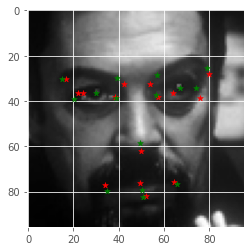

In [80]:
import matplotlib.pyplot as plt
img = final['pixel_value'][0][0]
print(img.size)
key_x = final['predicted_value_x'][0:15]
key_y = final['predicted_value_y'][0:15]
true_x = final['true_value_x'][0:15]
true_y = final['true_value_y'][0:15]
#print(key_x)
#print(key_y)

#print(key)
plt.imshow(img, cmap="gray")
plt.scatter(key_x*96,key_y*96, c='Red', marker='*')
plt.scatter(true_x*96,true_y*96, c='Green', marker='*')
#plt.savefig('/home/nandhini/NandhiniMathivananRnD/src/normal_01/evidential/face_evidential.png')

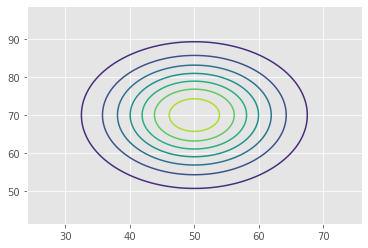

In [81]:
import numpy as np
import pdb
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal


def gauss2d(mu, sigma, to_plot=True):
    w, h = 100, 100
    sigma[0]
    std = [np.sqrt(sigma[0]), np.sqrt(sigma[1])]
    x = np.linspace(mu[0] - 3 * std[0], mu[0] + 3 * std[0], w)
    
    y = np.linspace(mu[1] - 3 * std[1], mu[1] + 3 * std[1], h)
    
    x, y = np.meshgrid(x, y)

    x_ = x.flatten()
    y_ = y.flatten()
    xy = np.vstack((x_, y_)).T

    normal_rv = multivariate_normal(mu, sigma)
    z = normal_rv.pdf(xy)
    z = z.reshape(w, h, order='F')


    return x,y,z


MU = [50, 70]
SIGMA = np.array([75.0, 90.0])
x,y,z = gauss2d(MU, SIGMA, True)
plt.contour(x, y, z.T)
plt.show()

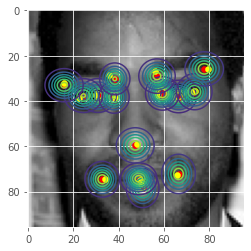

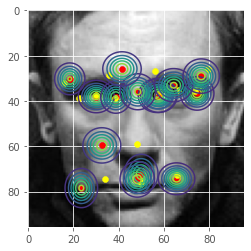

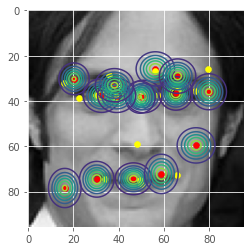

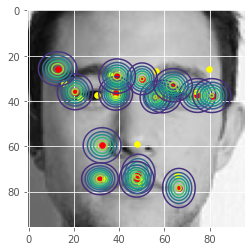

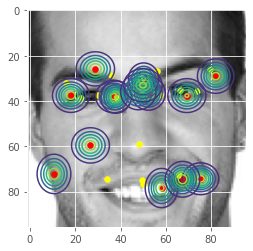

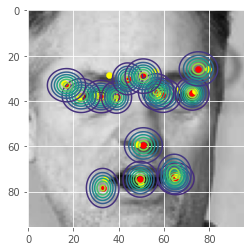

KeyboardInterrupt: 

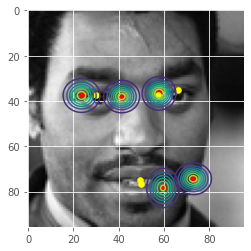

In [82]:
import matplotlib.pyplot as plt


for img_id in range(75):
    img = final1['pixel_value'].iloc[15*img_id]
    img = img.squeeze(0)
    plt.imshow(img, cmap="gray")
    for i,pred_x in enumerate(final1[ 'predicted_value_x'][15*img_id : 15*(img_id+1)].to_list()):
        pred_y = final1['predicted_value_y'].iloc[i]
        std_x =  final1['std_x'].iloc[i]
        std_y =  final1['std_y'].iloc[i]
        true_x = final1['true_value_x'].iloc[i]
        true_y = final1['true_value_y'].iloc[i]
        plt.scatter(pred_x*96,pred_y*96, c='Red', marker='o')
        plt.scatter(true_x*96,true_y*96, c='yellow', marker='o')

        MU = [pred_x*96,pred_y*96]
        SIGMA = np.array([std_x*96,std_y*96])
        x,y,z = gauss2d(MU, SIGMA, True)
        plt.contour(x, y, z.T)
        
        plt.savefig('/home/nandhini/NandhiniMathivananRnD/src/normal_01/evidential/most_error/test' + str(img_id) + ".png")
    plt.show()

   
    


#plt.scatter(z*96, c='Red', marker='*')
#plt.scatter(true_x*96,true_y*96, c='Green', marker='*')

#plt.savefig('/home/nandhini/NandhiniMathivananRnD/src/normal_01/gaussian/face_gaussian.png')

In [58]:
import scipy.stats 

def test_validation(model, valid_loader):
    
    model.eval()
#     model.to('cuda')
   
    val_difference =[]
    a = []
    b = []
    l = []
    m = []
    var = []
    img = []
    key = []

    with torch.no_grad():
        for i, [image,keypoints] in tqdm(enumerate(valid_loader)):
            
            image, keypoints = image.to(DEVICE), keypoints.to(DEVICE)
        
            keypoints = keypoints.view(keypoints.size(0), -1)
            mu,alpha,beta,lamda = model(image)
            variance = beta / ((alpha -1)*lamda)
            loss = EvidentialLoss(mu,alpha,beta,lamda, keypoints) 
  
            val_difference.extend(abs(keypoints - mu).squeeze(1).tolist())
            m.extend(mu.numpy().tolist())
            var.extend(variance.numpy())
            img.extend(image.numpy())
            key.extend(keypoints.numpy())
#             a.extend(alpha)
#             b.extend(beta)
#             l.extend(lamda)
 

   # print(scale)
    
    return m, var ,key ,img, val_difference
    

In [59]:
import torch
val_model = torch.load("/home/nandhini/NandhiniMathivananRnD/src/normal_01/evidential/ne.pth")
m, var ,key ,img, val_difference = test_validation(val_model, valid_loader)
print(m)

2it [00:02,  1.30s/it]

[[0.6681258678436279, 0.38102060556411743, 0.25107571482658386, 0.38112568855285645, 0.5984726548194885, 0.39885950088500977, 0.7922749519348145, 0.40457841753959656, 0.3992170989513397, 0.39726972579956055, 0.22729764878749847, 0.3786603808403015, 0.5591949820518494, 0.33912593126296997, 0.8301920890808105, 0.2931244969367981, 0.43908175826072693, 0.33735713362693787, 0.17516528069972992, 0.31638604402542114, 0.518162190914154, 0.6455492973327637, 0.6702272295951843, 0.7887242436408997, 0.35243934392929077, 0.8022565245628357, 0.5146990418434143, 0.7926923632621765, 0.5401541590690613, 0.8538852334022522], [0.657042920589447, 0.38742494583129883, 0.29654228687286377, 0.3890829384326935, 0.5823556184768677, 0.4006377160549164, 0.7792869806289673, 0.3991335332393646, 0.3886371850967407, 0.3771762549877167, 0.2738785743713379, 0.4134047329425812, 0.5548589825630188, 0.30993303656578064, 0.8070901036262512, 0.3027225732803345, 0.3831931948661804, 0.3423120379447937, 0.18485191464424133, 0

In [36]:
final2 = pd.DataFrame(columns=['image_label', 'keypoints','true_value','predicted_value','variance','val_difference','pixel_value'])

for i in range(len(img)):
    for j in range(len(var[i])):
        dictionary = pd.Series(data = {
        'image_label': i+1 ,
        'keypoints' : j+1 ,
        'true_value' : key[i][j],
        'predicted_value' :  m[i][j] ,
        'variance' : var[i][j],
        'val_difference' : val_difference[i][j],
        'pixel_value' : img [i]
        })

        final2 = final2.append(dictionary , ignore_index = True)

In [37]:
final2

,image_label,keypoints,true_value,predicted_value,variance,val_difference,pixel_value
0,1,1,0.696891,0.668126,0.024534,0.028765,"[[[22.0, 22.0, 22.0, 21.0, 21.0, 21.0, 21.0, 2..."
1,1,2,0.358050,0.381021,0.018762,0.022971,"[[[22.0, 22.0, 22.0, 21.0, 21.0, 21.0, 21.0, 2..."
2,1,3,0.313758,0.251076,0.034525,0.062682,"[[[22.0, 22.0, 22.0, 21.0, 21.0, 21.0, 21.0, 2..."
3,1,4,0.380679,0.381126,0.024864,0.000447,"[[[22.0, 22.0, 22.0, 21.0, 21.0, 21.0, 21.0, 2..."
4,1,5,0.589089,0.598473,0.018353,0.009384,"[[[22.0, 22.0, 22.0, 21.0, 21.0, 21.0, 21.0, 2..."
...,...,...,...,...,...,...,...
12835,428,26,0.805619,0.770717,0.033940,0.034902,"[[[68.0, 19.0, 19.0, 23.0, 19.0, 26.0, 23.0, 1..."
12836,428,27,0.537494,0.514967,0.028252,0.022527,"[[[68.0, 19.0, 19.0, 23.0, 19.0, 26.0, 23.0, 1..."
12837,428,28,0.791287,0.748279,0.016045,0.043009,"[[[68.0, 19.0, 19.0, 23.0, 19.0, 26.0, 23.0, 1..."
12838,428,29,0.551285,0.512103,0.023965,0.039182,"[[[68.0, 19.0, 19.0, 23.0, 19.0, 26.0, 23.0, 1..."


9216
0        0.668126
1        0.381021
2        0.251076
3        0.381126
4        0.598473
           ...   
12835    0.770717
12836    0.514967
12837    0.748279
12838    0.512103
12839    0.864166
Name: predicted_value, Length: 12840, dtype: float64


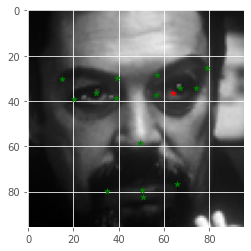

In [41]:
import matplotlib.pyplot as plt
img = final2['pixel_value'][0][0]
print(img.size)
key = final2['predicted_value']
print(key)
#key_y = final['predicted_value_y'][0:15]
true_x = final['true_value_x'][0:15]
true_y = final['true_value_y'][0:15]
#print(key_x)
#print(key_y)

#print(key)
plt.imshow(img, cmap="gray")
plt.scatter(key[0]*96,key[1]*96, c='Red', marker='*')
plt.scatter(true_x*96,true_y*96, c='Green', marker='*')

In [ ]:
import uncertainty_toolbox as uct
predictions = final2['predicted_value'].to_numpy()
print(type(predictions))

predictions_std = np.sqrt(final2['variance'].to_numpy())

Y_true = final2['true_value'].to_numpy()
#Y_true = Y_true.flatten()

metrics = uct.metrics.get_all_metrics(predictions, predictions_std, Y_true)

In [ ]:
import pandas as pd
vald_pred = pd.DataFrame(val_difference, columns=[str(i) for i in range(30)])


vald_pred ['exp_name'] = 'evidential'
vald_pred.to_csv('nef.csv')
vald_pred

In [ ]:
import seaborn as sns

In [ ]:
fig, ax = plt.subplots(figsize=(12, 3))
sns.set_style('white')
sns.boxplot( data=vald_pred, ax = ax, width=0.8)
sns.boxplot( data=vald_pred)
plt.savefig('nef.png')